# Multi Axion System

In [22]:
%run observables.py
%run multi_axion.py
from scipy.optimize import curve_fit
from scipy.fft import rfft, rfftfreq

In [3]:
Q = np.array([[1,1], [1, 0]])
Q_inv = np.linalg.inv(Q)
eps = 1e-3
Lambda = 1e7**2 * np.array([1, 1 + eps]) # [GeV^2]
thetas0 = [1, -1]
H_inf = Gamma_inf = 1e8
tmax_axion = 100

energy_scale, conv_factor, rho_R_init, rho_inf_init, scale, tmax_inf, red_chem_pots_init = \
    init_system(H_inf, Gamma_inf, (Q, Lambda), multi_axion_field, tmax_axion)
rh_sol, T_and_H_fn, T_and_H_and_T_dot_fn = decay_process.solve(tmax_inf, rho_R_init, rho_inf_init, scale, Gamma_inf)

axsol = multi_axion_field.solve(np.hstack([thetas0, np.zeros(len(Lambda))]), (Q, Lambda), tmax_axion, T_and_H_fn, Gamma_inf)

ts = np.linspace(0, tmax_axion, 500)
theta1s, theta2s, theta1_dots, theta2_dots = canoncial_states = axsol.sol(ts)
phi1s, phi2s, phi1_dots, phi2_dots = mass_states = multi_axion_field.calc_mass_state(canoncial_states, Q, Lambda)

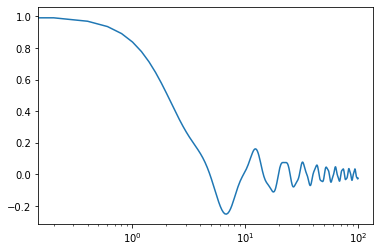

In [4]:
plt.semilogx(ts, theta1s)

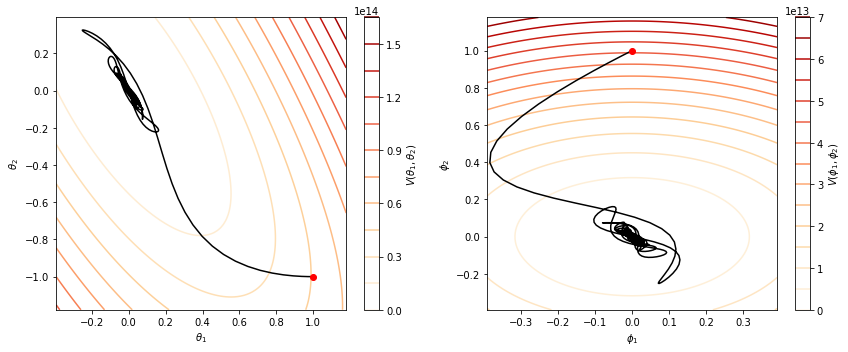

In [24]:
canonical_names = [r"$\theta_1$", r"$\theta_2$", r"$\dot{\theta}_1$", r"$\dot{\theta}_2$"]
mass_states_names = [r"$\phi_1$", r"$\phi_2$", r"$\dot{\phi}_1$", r"$\dot{\phi}_2$"]
tlabel = "t H"

skip = 0 # tspan / 10
s = skip_steps = int(np.ceil(skip / (ts[1] - ts[0])))

interval = np.pi / 8 #  np.pi / 4
def calc_range(x):
    return np.linspace(np.floor(np.min(x) / interval) * interval, np.ceil(np.max(x) / interval) * interval, 100)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
theta1_range, theta2_range = calc_range(theta1s[skip_steps:]), calc_range(theta2s[skip_steps:])
V = np.array([[multi_axion_field.calc_V([t1, t2], Q, Lambda) for t1 in theta1_range] for t2 in theta2_range])
plt.contour(theta1_range, theta2_range, V, levels=15, cmap="OrRd")
plt.plot(theta1s[skip_steps:], theta2s[skip_steps:], color="black")
plt.plot([theta1s[skip_steps]], [theta2s[skip_steps]], "ro")
plt.xlabel(canonical_names[0])
plt.ylabel(canonical_names[1])
plt.colorbar(label=r"$V(\theta_1, \theta_2)$")

plt.subplot(1, 2, 2)
phi1_range, phi2_range = calc_range(phi1s[skip_steps:]), calc_range(phi2s[skip_steps:])
V = np.array([[multi_axion_field.calc_V(Q_inv @ [t1, t2], Q, Lambda) for t1 in phi1_range] for t2 in phi2_range])
plt.contour(phi1_range, phi2_range, V, levels=15, cmap="OrRd")
plt.plot(phi1s[skip_steps:], phi2s[skip_steps:], color="black")
plt.plot([phi1s[skip_steps]], [phi2s[skip_steps]], "ro")
plt.xlabel(mass_states_names[0])
plt.ylabel(mass_states_names[1])
plt.colorbar(label=r"$V(\phi_1, \phi_2)$")

plt.tight_layout()
plt.savefig("config_space_trajectory_multi_axion.pdf")

Text(0.5, 1.0, 'alpha = -1.4952561379251554')

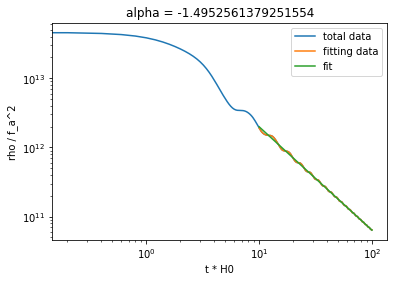

In [19]:
skip = tmax_axion / 10
s = skip_steps = int(np.ceil(skip / (ts[1] - ts[0])))
fake_f_a = 1
rho = np.array([ multi_axion_field.get_energy(x, fake_f_a, Q, Lambda) for x in canoncial_states.T ])
def fit_fn(log_t, alpha, log_beta):
    return alpha * log_t + log_beta
p, cov = curve_fit(fit_fn, np.log(ts[skip_steps:]), np.log(rho[skip_steps:]), p0=(1, 1))
alpha, log_beta = p

plt.figure()
plt.loglog(ts, rho, label="total data")
plt.loglog(ts[skip_steps:], rho[skip_steps:], label="fitting data")
plt.loglog(ts[skip_steps:], np.exp(fit_fn(np.log(ts[skip_steps:]), *p)), label="fit")
plt.xlabel("t * H0")
plt.ylabel("rho / f_a^2")
plt.legend()
plt.title(f"alpha = {p[0]}")

array([0.10080808, 0.2520202 , 0.66533333])

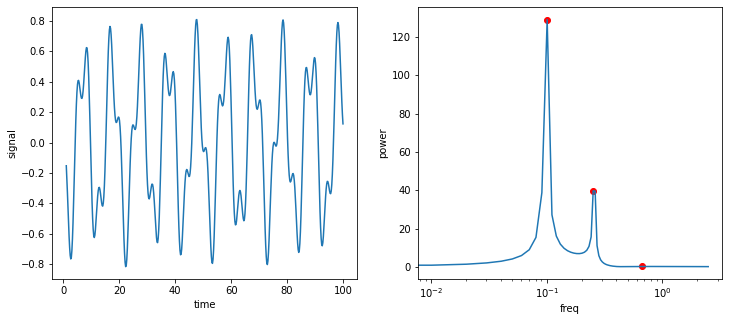

In [21]:
def analyse_power_spectrum(ts, var):
    tspan = ts[-1] - ts[0]
    skip = tspan / 100
    s = skip_steps = int(np.ceil(skip / (ts[1] - ts[0])))
    signal = var[s:] / ts[s:]**(alpha/2)
    dt = ts[1] - ts[0]
    freq = rfftfreq(len(signal), dt)
    ft = rfft(signal)
    pow_spec = np.abs(ft)
    is_local_max = (pow_spec[:-2] < pow_spec[1:-1]) & (pow_spec[2:] < pow_spec[1:-1])
    peaks = freq[1:-1][is_local_max]
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(ts[s:], signal)
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.subplot(1,2,2)
    plt.plot(peaks, pow_spec[1:-1][is_local_max], "or")
    plt.semilogx(freq, pow_spec)
    plt.xlabel("freq")
    plt.ylabel("power")
    return peaks
analyse_power_spectrum(ts, phi1s)